In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical, Normal
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import time

# Set random seeds for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

# Policy Gradient Methods Lab

## Part 1: REINFORCE for CartPole-v1

We'll implement two variants:
1. **REINFORCE** - vanilla policy gradient
2. **REINFORCE with Baseline** - using a learned value function to reduce variance

- **Policy Gradient Theorem**: ∇_θ J(θ) = E[∇_θ log π(A_t|S_t;θ) · G_t]
- **Baseline**: Subtract V(s) from returns to get advantages without introducing bias
- **CartPole-v1**: Balance a pole on a cart. State space: [position, velocity, angle, angular_velocity]. Actions: {0: push left, 1: push right}

In [5]:
class PolicyNetwork(nn.Module):
    """Policy network for discrete action spaces."""

    def __init__(self, state_dim, hidden_dims, action_dim):
        """
        Args:
            state_dim: Dimension of state space
            hidden_dims: List of hidden layer dimensions [64, 64]
            action_dim: Number of discrete actions
        """
        super(PolicyNetwork, self).__init__()

        # Build network layers
        layers = []
        prev_dim = state_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            prev_dim = hidden_dim

        # Output layer (logits)
        layers.append(nn.Linear(prev_dim, action_dim))

        self.network = nn.Sequential(*layers)

    def forward(self, state):
        """
        Forward pass to get action logits.

        Args:
            state: State tensor (batch_size, state_dim) or (state_dim,)
        Returns:
            logits: Action logits (batch_size, action_dim) or (action_dim,)
        """
        return self.network(state)

    def get_action_probs(self, state):
        """Get action probabilities via softmax."""
        logits = self.forward(state)
        return F.softmax(logits, dim=-1)

    def sample_action(self, state):
        """
        Sample an action from the policy.

        Args:
            state: State tensor
        Returns:
            action: Sampled action (scalar)
            log_prob: Log probability of the action
        """
        logits = self.forward(state)
        dist = Categorical(logits=logits)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action, log_prob

# Value Network (Baseline)

In [6]:
class ValueNetwork(nn.Module):
    """Value network for baseline estimation."""

    def __init__(self, state_dim, hidden_dims):
        """
        Args:
            state_dim: Dimension of state space
            hidden_dims: List of hidden layer dimensions [64, 64]
        """
        super(ValueNetwork, self).__init__()

        # Build network layers
        layers = []
        prev_dim = state_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            prev_dim = hidden_dim

        # Output layer (single value)
        layers.append(nn.Linear(prev_dim, 1))

        self.network = nn.Sequential(*layers)

    def forward(self, state):
        """
        Forward pass to get state value.

        Args:
            state: State tensor (batch_size, state_dim) or (state_dim,)
        Returns:
            value: State value (batch_size,) or scalar
        """
        value = self.network(state)
        return value.squeeze(-1)

# REINFORCE Algorithm

In [7]:
def compute_returns(rewards, gamma=0.99):
    """
    Compute discounted returns G_t for each timestep.

    Args:
        rewards: List of rewards [r_0, r_1, ..., r_T]
        gamma: Discount factor
    Returns:
        returns: List of returns [G_0, G_1, ..., G_T]
    """
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    return returns


def reinforce(env, policy, optimizer, num_episodes, gamma=0.99, seed=42):
    """
    REINFORCE algorithm (Monte Carlo Policy Gradient).

    Args:
        env: Gymnasium environment
        policy: Policy network
        optimizer: PyTorch optimizer for policy
        num_episodes: Number of episodes to train
        gamma: Discount factor
        seed: Random seed
    Returns:
        episode_returns: List of episode returns
        episode_lengths: List of episode lengths
    """
    set_seed(seed)

    episode_returns = []
    episode_lengths = []

    for episode in range(num_episodes):
        # Generate episode
        states, actions, rewards, log_probs = [], [], [], []
        state, _ = env.reset(seed=seed + episode)
        done = False

        while not done:
            # Convert state to tensor
            state_tensor = torch.FloatTensor(state).unsqueeze(0)

            # Sample action from policy
            action, log_prob = policy.sample_action(state_tensor)

            # Step environment
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated

            # Store transition
            states.append(state_tensor)
            actions.append(action)
            rewards.append(reward)
            log_probs.append(log_prob)

            state = next_state

        # Compute returns
        returns = compute_returns(rewards, gamma)
        returns_tensor = torch.FloatTensor(returns)

        # Normalize returns (variance reduction trick)
        if len(returns_tensor) > 1:
            returns_tensor = (returns_tensor - returns_tensor.mean()) / (returns_tensor.std() + 1e-8)

        # Compute policy gradient loss
        policy_loss = []
        for log_prob, G in zip(log_probs, returns_tensor):
            # Negative because we want gradient ascent (optimizer does descent)
            policy_loss.append(-log_prob * G)

        policy_loss = torch.stack(policy_loss).sum()

        # Update policy
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        # Record metrics
        episode_returns.append(sum(rewards))
        episode_lengths.append(len(rewards))

        # Print progress
        if (episode + 1) % 100 == 0:
            mean_return = np.mean(episode_returns[-100:])
            print(f"Episode {episode + 1}/{num_episodes}, "
                  f"Mean Return (last 100): {mean_return:.2f}")

    return episode_returns, episode_lengths

# REINFORCE with Baseline

In [8]:
def reinforce_with_baseline(env, policy, value_net, policy_optimizer,
                           value_optimizer, num_episodes, gamma=0.99, seed=42):
    """
    REINFORCE with learned baseline (value function).

    Args:
        env: Gymnasium environment
        policy: Policy network
        value_net: Value network (baseline)
        policy_optimizer: Optimizer for policy
        value_optimizer: Optimizer for value network
        num_episodes: Number of episodes to train
        gamma: Discount factor
        seed: Random seed
    Returns:
        episode_returns: List of episode returns
        episode_lengths: List of episode lengths
        value_losses: List of value function losses
    """
    set_seed(seed)

    episode_returns = []
    episode_lengths = []
    value_losses = []

    for episode in range(num_episodes):
        # Generate episode
        states, actions, rewards, log_probs = [], [], [], []
        state, _ = env.reset(seed=seed + episode)
        done = False

        while not done:
            # Convert state to tensor
            state_tensor = torch.FloatTensor(state).unsqueeze(0)

            # Sample action from policy
            action, log_prob = policy.sample_action(state_tensor)

            # Step environment
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated

            # Store transition
            states.append(state_tensor)
            actions.append(action)
            rewards.append(reward)
            log_probs.append(log_prob)

            state = next_state

        # Compute returns
        returns = compute_returns(rewards, gamma)
        returns_tensor = torch.FloatTensor(returns)

        # Get state values (baseline) for all states in episode
        state_batch = torch.cat(states)
        values = value_net(state_batch)

        # Compute advantages (returns - baseline)
        # Detach values to prevent gradients flowing into value network during policy update
        advantages = returns_tensor - values.detach()

        # Normalize advantages (variance reduction)
        if len(advantages) > 1:
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # Compute policy gradient loss
        policy_loss = []
        for log_prob, advantage in zip(log_probs, advantages):
            policy_loss.append(-log_prob * advantage)

        policy_loss = torch.stack(policy_loss).sum()

        # Compute value function loss (MSE with returns)
        value_loss = F.mse_loss(values, returns_tensor)

        # Update policy
        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()

        # Update value function
        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()

        # Record metrics
        episode_returns.append(sum(rewards))
        episode_lengths.append(len(rewards))
        value_losses.append(value_loss.item())

        # Print progress
        if (episode + 1) % 100 == 0:
            mean_return = np.mean(episode_returns[-100:])
            mean_value_loss = np.mean(value_losses[-100:])
            print(f"Episode {episode + 1}/{num_episodes}, "
                  f"Mean Return: {mean_return:.2f}, "
                  f"Value Loss: {mean_value_loss:.4f}")

    return episode_returns, episode_lengths, value_losses

# Training REINFORCE on CartPole-v1


In [9]:
# Create environment
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]  # 4
action_dim = env.action_space.n  # 2

print(f"State dimension: {state_dim}")
print(f"Action dimension: {action_dim}")

# Hyperparameters
hidden_dims = [128, 128]
learning_rate = 1e-3
num_episodes = 1000
gamma = 0.99
num_seeds = 5

# Train REINFORCE with multiple seeds
print("\n" + "="*60)
print("Training REINFORCE (vanilla)")
print("="*60)

all_returns_reinforce = []
all_lengths_reinforce = []

for seed in range(num_seeds):
    print(f"\nSeed {seed + 1}/{num_seeds}")

    # Create fresh networks
    policy = PolicyNetwork(state_dim, hidden_dims, action_dim)
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

    # Train
    returns, lengths = reinforce(env, policy, optimizer, num_episodes, gamma, seed=seed)

    all_returns_reinforce.append(returns)
    all_lengths_reinforce.append(lengths)

    # Save model
    torch.save({
        'policy_state_dict': policy.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'returns': returns,
    }, f'reinforce_cartpole_seed{seed}.pth')

env.close()

State dimension: 4
Action dimension: 2

Training REINFORCE (vanilla)

Seed 1/5
Episode 100/1000, Mean Return (last 100): 35.54
Episode 200/1000, Mean Return (last 100): 124.01
Episode 300/1000, Mean Return (last 100): 199.66
Episode 400/1000, Mean Return (last 100): 340.24
Episode 500/1000, Mean Return (last 100): 267.49
Episode 600/1000, Mean Return (last 100): 161.79
Episode 700/1000, Mean Return (last 100): 464.14
Episode 800/1000, Mean Return (last 100): 449.14
Episode 900/1000, Mean Return (last 100): 223.07
Episode 1000/1000, Mean Return (last 100): 499.14

Seed 2/5
Episode 100/1000, Mean Return (last 100): 46.63
Episode 200/1000, Mean Return (last 100): 186.51
Episode 300/1000, Mean Return (last 100): 261.71
Episode 400/1000, Mean Return (last 100): 186.04
Episode 500/1000, Mean Return (last 100): 419.66
Episode 600/1000, Mean Return (last 100): 427.43
Episode 700/1000, Mean Return (last 100): 460.69
Episode 800/1000, Mean Return (last 100): 492.25
Episode 900/1000, Mean Return 

# Training REINFORCE with Baseline

In [10]:
# Create environment
env = gym.make('CartPole-v1')

print("\n" + "="*60)
print("Training REINFORCE with Baseline")
print("="*60)

all_returns_baseline = []
all_lengths_baseline = []
all_value_losses = []

for seed in range(num_seeds):
    print(f"\nSeed {seed + 1}/{num_seeds}")

    # Create fresh networks
    policy = PolicyNetwork(state_dim, hidden_dims, action_dim)
    value_net = ValueNetwork(state_dim, hidden_dims)

    policy_optimizer = optim.Adam(policy.parameters(), lr=learning_rate)
    value_optimizer = optim.Adam(value_net.parameters(), lr=learning_rate)

    # Train
    returns, lengths, v_losses = reinforce_with_baseline(
        env, policy, value_net, policy_optimizer, value_optimizer,
        num_episodes, gamma, seed=seed
    )

    all_returns_baseline.append(returns)
    all_lengths_baseline.append(lengths)
    all_value_losses.append(v_losses)

    # Save model
    torch.save({
        'policy_state_dict': policy.state_dict(),
        'value_state_dict': value_net.state_dict(),
        'policy_optimizer_state_dict': policy_optimizer.state_dict(),
        'value_optimizer_state_dict': value_optimizer.state_dict(),
        'returns': returns,
        'value_losses': v_losses,
    }, f'reinforce_baseline_cartpole_seed{seed}.pth')

env.close()


Training REINFORCE with Baseline

Seed 1/5
Episode 100/1000, Mean Return: 45.63, Value Loss: 295.0802
Episode 200/1000, Mean Return: 141.38, Value Loss: 597.9674
Episode 300/1000, Mean Return: 253.81, Value Loss: 765.6349
Episode 400/1000, Mean Return: 246.97, Value Loss: 264.2625
Episode 500/1000, Mean Return: 443.76, Value Loss: 540.2581
Episode 600/1000, Mean Return: 468.13, Value Loss: 577.0836
Episode 700/1000, Mean Return: 482.49, Value Loss: 642.0229
Episode 800/1000, Mean Return: 492.91, Value Loss: 570.5178
Episode 900/1000, Mean Return: 493.22, Value Loss: 489.1520
Episode 1000/1000, Mean Return: 484.24, Value Loss: 584.8986

Seed 2/5
Episode 100/1000, Mean Return: 30.98, Value Loss: 168.7851
Episode 200/1000, Mean Return: 95.83, Value Loss: 487.5339
Episode 300/1000, Mean Return: 149.50, Value Loss: 494.2581
Episode 400/1000, Mean Return: 384.88, Value Loss: 912.3202
Episode 500/1000, Mean Return: 459.55, Value Loss: 666.9415
Episode 600/1000, Mean Return: 404.83, Value Los

In [11]:
def smooth(data, window=50):
    """Smooth data using moving average."""
    if len(data) < window:
        return data
    smoothed = np.convolve(data, np.ones(window)/window, mode='valid')
    return smoothed


def plot_learning_curves(all_returns_reinforce, all_returns_baseline,
                         window=50, save_path='learning_curves.png'):
    """
    Plot learning curves comparing REINFORCE and REINFORCE with Baseline.

    Shows mean and confidence intervals across multiple seeds.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

    # Convert to arrays
    returns_rf = np.array(all_returns_reinforce)
    returns_bl = np.array(all_returns_baseline)

    # Smooth returns
    smoothed_rf = np.array([smooth(r, window) for r in returns_rf])
    smoothed_bl = np.array([smooth(r, window) for r in returns_bl])

    # Compute statistics
    mean_rf = smoothed_rf.mean(axis=0)
    std_rf = smoothed_rf.std(axis=0)
    mean_bl = smoothed_bl.mean(axis=0)
    std_bl = smoothed_bl.std(axis=0)

    episodes_rf = np.arange(len(mean_rf))
    episodes_bl = np.arange(len(mean_bl))

    # Plot 1: Mean returns with confidence intervals
    ax1.plot(episodes_rf, mean_rf, label='REINFORCE', color='blue', linewidth=2)
    ax1.fill_between(episodes_rf, mean_rf - std_rf, mean_rf + std_rf,
                     color='blue', alpha=0.2)

    ax1.plot(episodes_bl, mean_bl, label='REINFORCE with Baseline',
             color='red', linewidth=2)
    ax1.fill_between(episodes_bl, mean_bl - std_bl, mean_bl + std_bl,
                     color='red', alpha=0.2)

    ax1.axhline(y=500, color='green', linestyle='--',
                label='Solved Threshold (500)', linewidth=1.5)
    ax1.set_xlabel('Episode', fontsize=12)
    ax1.set_ylabel(f'Return (smoothed, window={window})', fontsize=12)
    ax1.set_title('Learning Curves: Mean Return', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Plot 2: Variance (std) over episodes
    ax2.plot(episodes_rf, std_rf, label='REINFORCE', color='blue', linewidth=2)
    ax2.plot(episodes_bl, std_bl, label='REINFORCE with Baseline',
             color='red', linewidth=2)

    ax2.set_xlabel('Episode', fontsize=12)
    ax2.set_ylabel('Standard Deviation of Returns', fontsize=12)
    ax2.set_title('Variance Across Seeds', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    # Print final statistics
    print(f"\n{'='*60}")
    print("Final Performance (last 100 episodes)")
    print(f"{'='*60}")
    print(f"REINFORCE:")
    print(f"  Mean Return: {returns_rf[:, -100:].mean():.2f} ± {returns_rf[:, -100:].std():.2f}")
    print(f"\nREINFORCE with Baseline:")
    print(f"  Mean Return: {returns_bl[:, -100:].mean():.2f} ± {returns_bl[:, -100:].std():.2f}")

    # Calculate episodes to solve (return >= 475 for 100 consecutive episodes)
    def episodes_to_solve(returns_list, threshold=475, window=100):
        episodes = []
        for returns in returns_list:
            smoothed = smooth(returns, window)
            solved = np.where(smoothed >= threshold)[0]
            if len(solved) > 0:
                episodes.append(solved[0] + window)
            else:
                episodes.append(len(returns))
        return episodes

    rf_solve = episodes_to_solve(all_returns_reinforce)
    bl_solve = episodes_to_solve(all_returns_baseline)

    print(f"\nEpisodes to Solve (>= 475 for 100 consecutive episodes):")
    print(f"  REINFORCE: {np.mean(rf_solve):.0f} ± {np.std(rf_solve):.0f}")
    print(f"  REINFORCE with Baseline: {np.mean(bl_solve):.0f} ± {np.std(bl_solve):.0f}")

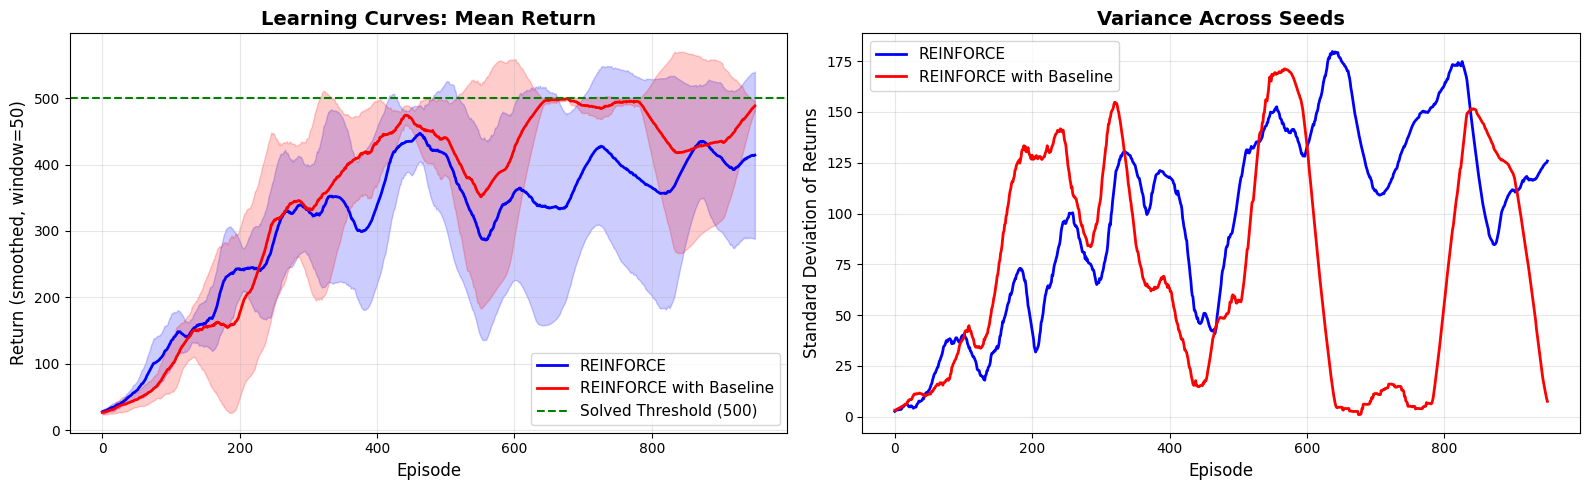


Final Performance (last 100 episodes)
REINFORCE:
  Mean Return: 412.72 ± 137.77

REINFORCE with Baseline:
  Mean Return: 461.66 ± 101.19

Episodes to Solve (>= 475 for 100 consecutive episodes):
  REINFORCE: 605 ± 107
  REINFORCE with Baseline: 514 ± 89


In [12]:
# Plot the learning curves
plot_learning_curves(all_returns_reinforce, all_returns_baseline,
                    window=50, save_path='cartpole_learning_curves.png')

---

## Part 2: Actor-Critic for Continuous Control

We'll implement a one-step Actor-Critic algorithm for continuous action spaces:
- **Actor**: Outputs Gaussian policy parameters (mean μ and log-std)
- **Critic**: Outputs state value V(s)
- **Update**: After each step using TD(0) error

### Environment: Pendulum-v1
- **State**: [cos(θ), sin(θ), angular_velocity] (3D continuous)
- **Action**: Torque in [-2, 2] (1D continuous)
- **Goal**: Keep pendulum upright (minimize angle and velocity)

# Continuous Actor-Critic Network

In [13]:
class ContinuousActorCritic(nn.Module):
    """
    Actor-Critic network for continuous action spaces.

    Architecture:
    - Shared layers for feature extraction
    - Actor head: outputs mean of Gaussian policy
    - Learned log-std parameter (state-independent)
    - Critic head: outputs state value
    """

    def __init__(self, state_dim, action_dim, hidden_dim=128, init_log_std=0.0):
        """
        Args:
            state_dim: Dimension of state space
            action_dim: Dimension of action space
            hidden_dim: Size of hidden layers
            init_log_std: Initial value for log standard deviation
        """
        super(ContinuousActorCritic, self).__init__()

        # Shared feature extractor
        self.shared = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # Actor head (outputs mean of Gaussian)
        self.actor_mean = nn.Linear(hidden_dim, action_dim)

        # Learnable log standard deviation (state-independent)
        self.actor_log_std = nn.Parameter(torch.ones(action_dim) * init_log_std)

        # Critic head (outputs state value)
        self.critic = nn.Linear(hidden_dim, 1)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize network weights."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=np.sqrt(2))
                nn.init.constant_(m.bias, 0.0)

        # Small initialization for actor output
        nn.init.orthogonal_(self.actor_mean.weight, gain=0.01)
        nn.init.constant_(self.actor_mean.bias, 0.0)

    def forward(self, state):
        """
        Forward pass through the network.

        Args:
            state: State tensor (batch_size, state_dim) or (state_dim,)
        Returns:
            mean: Mean of Gaussian policy (batch_size, action_dim) or (action_dim,)
            std: Standard deviation (batch_size, action_dim) or (action_dim,)
            value: State value (batch_size,) or scalar
        """
        # Shared features
        features = self.shared(state)

        # Actor: Gaussian policy parameters
        mean = self.actor_mean(features)
        std = torch.exp(self.actor_log_std)  # Ensure std > 0

        # Critic: state value
        value = self.critic(features).squeeze(-1)

        return mean, std, value

    def sample_action(self, state):
        """
        Sample an action from the policy.

        Args:
            state: State tensor
        Returns:
            action: Sampled action
            log_prob: Log probability of the action
            value: State value
        """
        mean, std, value = self.forward(state)

        # Create Gaussian distribution
        dist = Normal(mean, std)

        # Sample action
        action = dist.sample()

        # Compute log probability (sum over action dimensions)
        log_prob = dist.log_prob(action).sum(dim=-1)

        return action, log_prob, value

    def evaluate_action(self, state, action):
        """
        Evaluate log probability and entropy for given state-action pair.

        Args:
            state: State tensor
            action: Action tensor
        Returns:
            log_prob: Log probability of action
            value: State value
            entropy: Policy entropy
        """
        mean, std, value = self.forward(state)

        # Create Gaussian distribution
        dist = Normal(mean, std)

        # Log probability
        log_prob = dist.log_prob(action).sum(dim=-1)

        # Entropy (for Gaussian: 0.5 * log(2πeσ²))
        entropy = dist.entropy().sum(dim=-1)

        return log_prob, value, entropy

# Actor-Critic Training Algorithm

In [14]:
def actor_critic_train(env, model, optimizer, num_episodes, gamma=0.99,
                      entropy_coef=0.01, max_steps=1000, seed=42):
    """
    One-step Actor-Critic algorithm for continuous action spaces.

    Args:
        env: Gymnasium environment
        model: ContinuousActorCritic network
        optimizer: PyTorch optimizer
        num_episodes: Number of episodes to train
        gamma: Discount factor
        entropy_coef: Coefficient for entropy regularization
        max_steps: Maximum steps per episode
        seed: Random seed
    Returns:
        episode_returns: List of episode returns
        episode_lengths: List of episode lengths
        td_errors: List of TD errors per episode
        entropies: List of policy entropies per episode
    """
    set_seed(seed)

    episode_returns = []
    episode_lengths = []
    td_errors_per_episode = []
    entropies_per_episode = []

    for episode in range(num_episodes):
        state, _ = env.reset(seed=seed + episode)
        total_reward = 0
        done = False
        steps = 0

        td_errors = []
        entropies = []

        while not done and steps < max_steps:
            # Convert state to tensor
            state_tensor = torch.FloatTensor(state).unsqueeze(0)

            # Sample action from policy
            action, log_prob, value = model.sample_action(state_tensor)

            # Clip action to environment bounds
            action_numpy = action.detach().numpy().flatten()
            action_clipped = np.clip(
                action_numpy,
                env.action_space.low,
                env.action_space.high
            )

            # Step environment
            next_state, reward, terminated, truncated, _ = env.step(action_clipped)
            done = terminated or truncated
            total_reward += reward
            steps += 1

            # Compute TD target and error
            if not done:
                next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
                _, _, next_value = model.sample_action(next_state_tensor)
                td_target = reward + gamma * next_value
            else:
                td_target = torch.tensor(reward, dtype=torch.float32)

            td_error = td_target - value

            # Compute entropy for logging
            _, _, entropy = model.evaluate_action(state_tensor, action)

            # Actor loss: policy gradient with entropy regularization
            actor_loss = -log_prob * td_error.detach()  # Detach to stop gradients through critic
            actor_loss = actor_loss - entropy_coef * entropy  # Entropy bonus

            # Critic loss: TD error squared
            critic_loss = td_error ** 2

            # Combined loss
            total_loss = actor_loss + critic_loss

            # Update networks
            optimizer.zero_grad()
            total_loss.backward()

            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            # Record metrics
            td_errors.append(abs(td_error.item()))
            entropies.append(entropy.item())

            state = next_state

        # Record episode metrics
        episode_returns.append(total_reward)
        episode_lengths.append(steps)
        td_errors_per_episode.append(np.mean(td_errors))
        entropies_per_episode.append(np.mean(entropies))

        # Print progress
        if (episode + 1) % 50 == 0:
            mean_return = np.mean(episode_returns[-50:])
            mean_entropy = np.mean(entropies_per_episode[-50:])
            print(f"Episode {episode + 1}/{num_episodes}, "
                  f"Mean Return: {mean_return:.2f}, "
                  f"Mean Entropy: {mean_entropy:.4f}")

    return episode_returns, episode_lengths, td_errors_per_episode, entropies_per_episode

# Training Actor-Critic on Pendulum-v1

In [15]:
# Create environment
env = gym.make('Pendulum-v1')
state_dim = env.observation_space.shape[0]  # 3
action_dim = env.action_space.shape[0]  # 1

print(f"State dimension: {state_dim}")
print(f"Action dimension: {action_dim}")
print(f"Action space bounds: [{env.action_space.low[0]}, {env.action_space.high[0]}]")

# Hyperparameters for Pendulum
hidden_dim = 128
learning_rate = 3e-4
num_episodes = 300
gamma = 0.99
entropy_coef = 0.01
init_log_std = 0.0
num_seeds = 3

print("\n" + "="*60)
print("Training Actor-Critic on Pendulum-v1")
print("="*60)
print(f"Hyperparameters:")
print(f"  Hidden dim: {hidden_dim}")
print(f"  Learning rate: {learning_rate}")
print(f"  Entropy coefficient: {entropy_coef}")
print(f"  Initial log std: {init_log_std}")
print(f"  Gamma: {gamma}")

all_returns_ac = []
all_lengths_ac = []
all_td_errors_ac = []
all_entropies_ac = []

for seed in range(num_seeds):
    print(f"\n{'='*60}")
    print(f"Seed {seed + 1}/{num_seeds}")
    print(f"{'='*60}")

    # Create fresh network
    model = ContinuousActorCritic(state_dim, action_dim, hidden_dim, init_log_std)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train
    returns, lengths, td_errors, entropies = actor_critic_train(
        env, model, optimizer, num_episodes, gamma, entropy_coef,
        max_steps=200, seed=seed
    )

    all_returns_ac.append(returns)
    all_lengths_ac.append(lengths)
    all_td_errors_ac.append(td_errors)
    all_entropies_ac.append(entropies)

    # Save model
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'returns': returns,
        'td_errors': td_errors,
        'entropies': entropies,
        'hyperparameters': {
            'hidden_dim': hidden_dim,
            'learning_rate': learning_rate,
            'entropy_coef': entropy_coef,
            'init_log_std': init_log_std,
            'gamma': gamma,
        }
    }, f'actor_critic_pendulum_seed{seed}.pth')

env.close()

State dimension: 3
Action dimension: 1
Action space bounds: [-2.0, 2.0]

Training Actor-Critic on Pendulum-v1
Hyperparameters:
  Hidden dim: 128
  Learning rate: 0.0003
  Entropy coefficient: 0.01
  Initial log std: 0.0
  Gamma: 0.99

Seed 1/3
Episode 50/300, Mean Return: -1366.32, Mean Entropy: 1.8330
Episode 100/300, Mean Return: -1612.25, Mean Entropy: 2.5524
Episode 150/300, Mean Return: -1364.55, Mean Entropy: 2.7938
Episode 200/300, Mean Return: -1408.89, Mean Entropy: 2.9789
Episode 250/300, Mean Return: -1394.01, Mean Entropy: 3.1807
Episode 300/300, Mean Return: -1409.76, Mean Entropy: 3.3534

Seed 2/3
Episode 50/300, Mean Return: -1458.24, Mean Entropy: 1.8729
Episode 100/300, Mean Return: -1593.90, Mean Entropy: 2.4748
Episode 150/300, Mean Return: -1460.98, Mean Entropy: 2.6443
Episode 200/300, Mean Return: -1486.48, Mean Entropy: 2.7862
Episode 250/300, Mean Return: -1435.69, Mean Entropy: 2.9612
Episode 300/300, Mean Return: -1457.69, Mean Entropy: 3.0977

Seed 3/3
Episod

In [16]:
def plot_actor_critic_results(all_returns, all_td_errors, all_entropies,
                             window=10, save_path='ac_results.png'):
    """
    Plot Actor-Critic training results.

    Shows:
    1. Episode returns
    2. Policy entropy over time
    3. TD error magnitude
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # Convert to arrays
    returns = np.array(all_returns)
    td_errors = np.array(all_td_errors)
    entropies = np.array(all_entropies)

    # Smooth data
    smoothed_returns = np.array([smooth(r, window) for r in returns])
    smoothed_td = np.array([smooth(td, window) for td in td_errors])
    smoothed_entropy = np.array([smooth(e, window) for e in entropies])

    # Compute statistics
    mean_returns = smoothed_returns.mean(axis=0)
    std_returns = smoothed_returns.std(axis=0)
    mean_td = smoothed_td.mean(axis=0)
    std_td = smoothed_td.std(axis=0)
    mean_entropy = smoothed_entropy.mean(axis=0)
    std_entropy = smoothed_entropy.std(axis=0)

    episodes = np.arange(len(mean_returns))

    # Plot 1: Returns
    ax = axes[0, 0]
    ax.plot(episodes, mean_returns, color='blue', linewidth=2, label='Mean')
    ax.fill_between(episodes, mean_returns - std_returns, mean_returns + std_returns,
                    color='blue', alpha=0.2, label='±1 std')
    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel(f'Return (smoothed, window={window})', fontsize=12)
    ax.set_title('Episode Returns', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

    # Plot 2: Policy Entropy
    ax = axes[0, 1]
    ax.plot(episodes, mean_entropy, color='green', linewidth=2, label='Mean')
    ax.fill_between(episodes, mean_entropy - std_entropy, mean_entropy + std_entropy,
                    color='green', alpha=0.2, label='±1 std')
    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Policy Entropy', fontsize=12)
    ax.set_title('Policy Entropy Over Time', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

    # Plot 3: TD Error
    ax = axes[1, 0]
    ax.plot(episodes, mean_td, color='red', linewidth=2, label='Mean')
    ax.fill_between(episodes, mean_td - std_td, mean_td + std_td,
                    color='red', alpha=0.2, label='±1 std')
    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('|TD Error|', fontsize=12)
    ax.set_title('TD Error Magnitude', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

    # Plot 4: Learning progress (cumulative return)
    ax = axes[1, 1]
    for i, r in enumerate(returns):
        smoothed = smooth(r, window=20)
        ax.plot(smoothed, alpha=0.6, linewidth=1, label=f'Seed {i+1}')
    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel(f'Return (smoothed, window=20)', fontsize=12)
    ax.set_title('Learning Progress (All Seeds)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    # Print statistics
    print(f"\n{'='*60}")
    print("Final Performance (last 50 episodes)")
    print(f"{'='*60}")
    print(f"Mean Return: {returns[:, -50:].mean():.2f} ± {returns[:, -50:].std():.2f}")
    print(f"Mean Entropy: {entropies[:, -50:].mean():.4f} ± {entropies[:, -50:].std():.4f}")
    print(f"Mean TD Error: {td_errors[:, -50:].mean():.4f} ± {td_errors[:, -50:].std():.4f}")

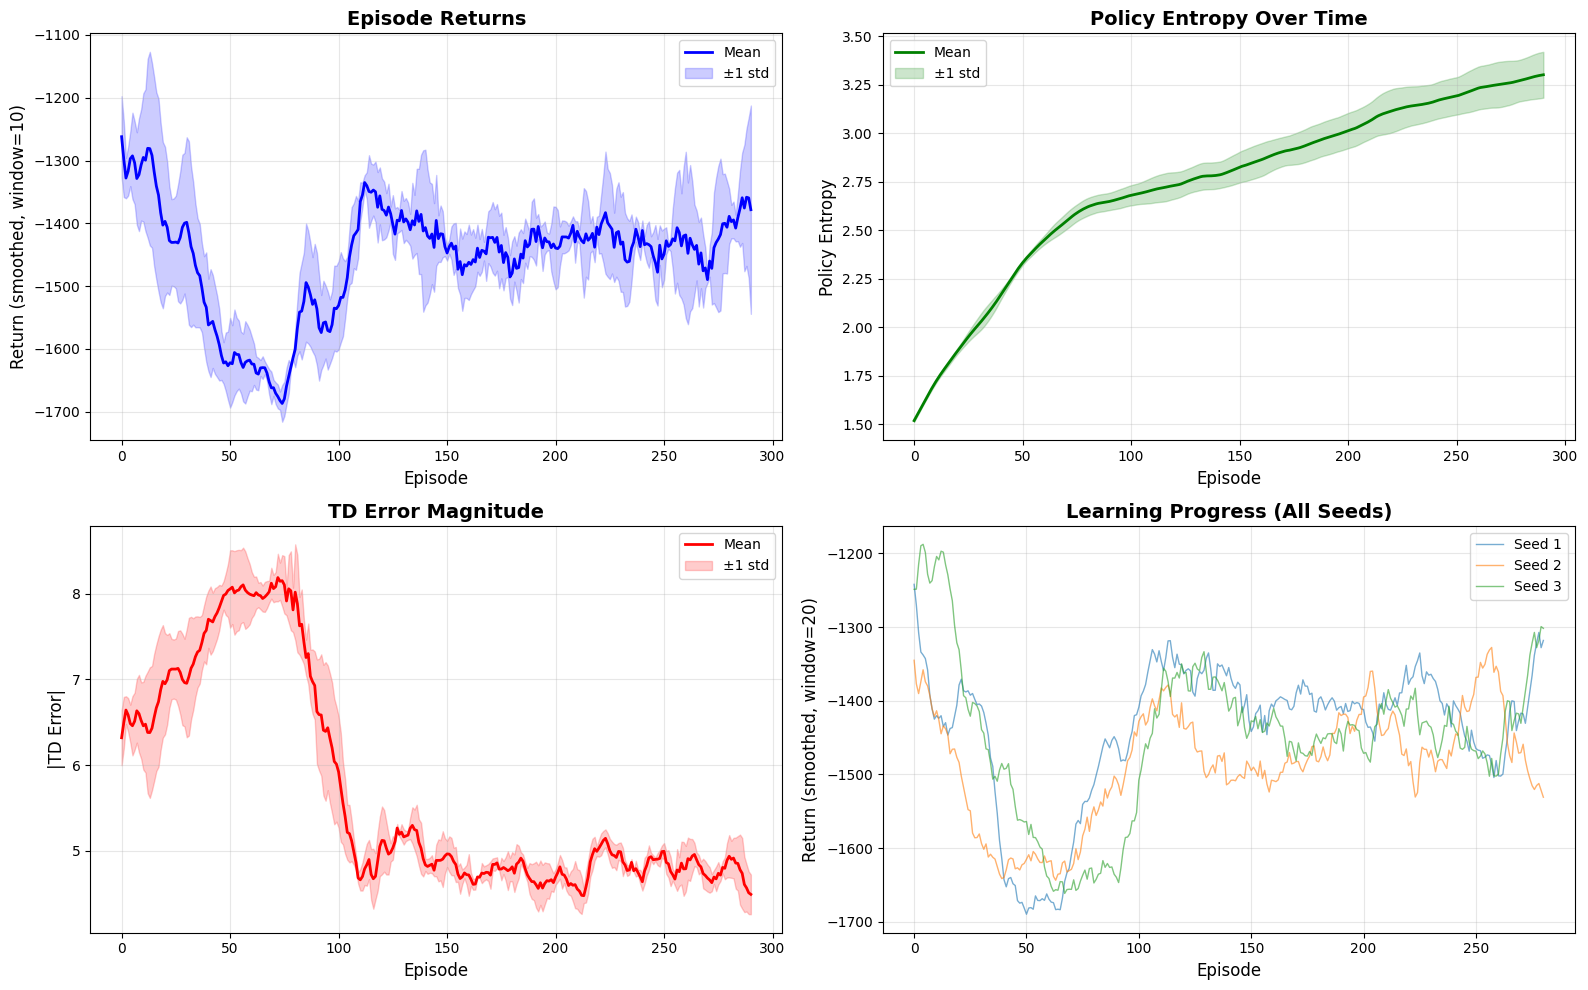


Final Performance (last 50 episodes)
Mean Return: -1424.88 ± 246.45
Mean Entropy: 3.2493 ± 0.1167
Mean TD Error: 4.7781 ± 0.7409


In [17]:
# Plot the results
plot_actor_critic_results(all_returns_ac, all_td_errors_ac, all_entropies_ac,
                         window=10, save_path='pendulum_ac_results.png')

In [18]:
def visualize_policy(model, env_name='Pendulum-v1', save_path='policy_heatmap.png'):
    """
    Visualize the learned policy across the state space.

    For Pendulum:
    - X-axis: angle (θ in [-π, π])
    - Y-axis: angular velocity (θ_dot in [-8, 8])
    - Color: mean action (torque)
    """
    env = gym.make(env_name)

    # Create grid of states
    n_points = 50
    angles = np.linspace(-np.pi, np.pi, n_points)
    velocities = np.linspace(-8, 8, n_points)

    # Initialize arrays for policy outputs
    mean_actions = np.zeros((n_points, n_points))
    std_actions = np.zeros((n_points, n_points))
    values = np.zeros((n_points, n_points))

    model.eval()
    with torch.no_grad():
        for i, angle in enumerate(angles):
            for j, velocity in enumerate(velocities):
                # Construct state [cos(θ), sin(θ), θ_dot]
                state = np.array([np.cos(angle), np.sin(angle), velocity])
                state_tensor = torch.FloatTensor(state).unsqueeze(0)

                # Get policy outputs
                mean, std, value = model(state_tensor)

                mean_actions[j, i] = mean.item()
                std_actions[j, i] = std.item()
                values[j, i] = value.item()

    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot 1: Mean action (policy)
    ax = axes[0]
    im1 = ax.imshow(mean_actions, extent=[-np.pi, np.pi, -8, 8],
                    aspect='auto', origin='lower', cmap='RdBu_r')
    ax.set_xlabel('Angle θ (radians)', fontsize=12)
    ax.set_ylabel('Angular Velocity dθ/dt', fontsize=12)
    ax.set_title('Policy: Mean Action (Torque)', fontsize=14, fontweight='bold')
    plt.colorbar(im1, ax=ax, label='Torque')

    # Mark upright position
    ax.axvline(x=0, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Upright')
    ax.legend()

    # Plot 2: Standard deviation
    ax = axes[1]
    im2 = ax.imshow(std_actions, extent=[-np.pi, np.pi, -8, 8],
                    aspect='auto', origin='lower', cmap='viridis')
    ax.set_xlabel('Angle θ (radians)', fontsize=12)
    ax.set_ylabel('Angular Velocity dθ/dt', fontsize=12)
    ax.set_title('Policy: Standard Deviation', fontsize=14, fontweight='bold')
    plt.colorbar(im2, ax=ax, label='Std Dev')
    ax.axvline(x=0, color='green', linestyle='--', linewidth=2, alpha=0.7)

    # Plot 3: State values
    ax = axes[2]
    im3 = ax.imshow(values, extent=[-np.pi, np.pi, -8, 8],
                    aspect='auto', origin='lower', cmap='plasma')
    ax.set_xlabel('Angle θ (radians)', fontsize=12)
    ax.set_ylabel('Angular Velocity dθ/dt', fontsize=12)
    ax.set_title('Critic: State Values V(s)', fontsize=14, fontweight='bold')
    plt.colorbar(im3, ax=ax, label='Value')
    ax.axvline(x=0, color='green', linestyle='--', linewidth=2, alpha=0.7)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    env.close()


def plot_sample_trajectories(model, env_name='Pendulum-v1', num_episodes=3,
                            save_path='trajectories.png'):
    """
    Plot sample trajectories from the learned policy.
    """
    env = gym.make(env_name)

    fig, axes = plt.subplots(num_episodes, 3, figsize=(15, 4*num_episodes))
    if num_episodes == 1:
        axes = axes.reshape(1, -1)

    model.eval()
    with torch.no_grad():
        for ep in range(num_episodes):
            state, _ = env.reset()
            states = [state]
            actions = []
            rewards = []
            done = False
            steps = 0
            max_steps = 200

            while not done and steps < max_steps:
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                action, _, _ = model.sample_action(state_tensor)

                action_numpy = action.numpy().flatten()
                action_clipped = np.clip(action_numpy, env.action_space.low,
                                       env.action_space.high)

                next_state, reward, terminated, truncated, _ = env.step(action_clipped)
                done = terminated or truncated

                states.append(next_state)
                actions.append(action_clipped[0])
                rewards.append(reward)

                state = next_state
                steps += 1

            # Extract state components
            states = np.array(states[:-1])
            cos_theta = states[:, 0]
            sin_theta = states[:, 1]
            theta = np.arctan2(sin_theta, cos_theta)
            theta_dot = states[:, 2]

            timesteps = np.arange(len(theta))

            # Plot angle
            ax = axes[ep, 0]
            ax.plot(timesteps, theta, linewidth=2)
            ax.axhline(y=0, color='green', linestyle='--', alpha=0.7, label='Upright')
            ax.set_xlabel('Timestep', fontsize=11)
            ax.set_ylabel('Angle θ (radians)', fontsize=11)
            ax.set_title(f'Episode {ep+1}: Angle', fontsize=12, fontweight='bold')
            ax.legend()
            ax.grid(True, alpha=0.3)

            # Plot angular velocity
            ax = axes[ep, 1]
            ax.plot(timesteps, theta_dot, linewidth=2, color='orange')
            ax.axhline(y=0, color='green', linestyle='--', alpha=0.7)
            ax.set_xlabel('Timestep', fontsize=11)
            ax.set_ylabel('Angular Velocity', fontsize=11)
            ax.set_title(f'Episode {ep+1}: Angular Velocity', fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3)

            # Plot actions and rewards
            ax = axes[ep, 2]
            ax2 = ax.twinx()

            line1 = ax.plot(timesteps, actions, linewidth=2, color='blue', label='Action (Torque)')
            line2 = ax2.plot(timesteps, rewards, linewidth=2, color='red',
                           alpha=0.7, label='Reward')

            ax.set_xlabel('Timestep', fontsize=11)
            ax.set_ylabel('Action (Torque)', fontsize=11, color='blue')
            ax2.set_ylabel('Reward', fontsize=11, color='red')
            ax.tick_params(axis='y', labelcolor='blue')
            ax2.tick_params(axis='y', labelcolor='red')
            ax.set_title(f'Episode {ep+1}: Actions & Rewards (Return={sum(rewards):.1f})',
                        fontsize=12, fontweight='bold')

            lines = line1 + line2
            labels = [l.get_label() for l in lines]
            ax.legend(lines, labels, loc='upper right')
            ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    env.close()

/tmp/ipython-input-3105437469.py:3: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.multiarray.
  torch.serialization.add_safe_globals([np.core.multiarray.scalar])


Loaded best model from seed 2
Final mean return: -1407.19

Generating policy visualization...


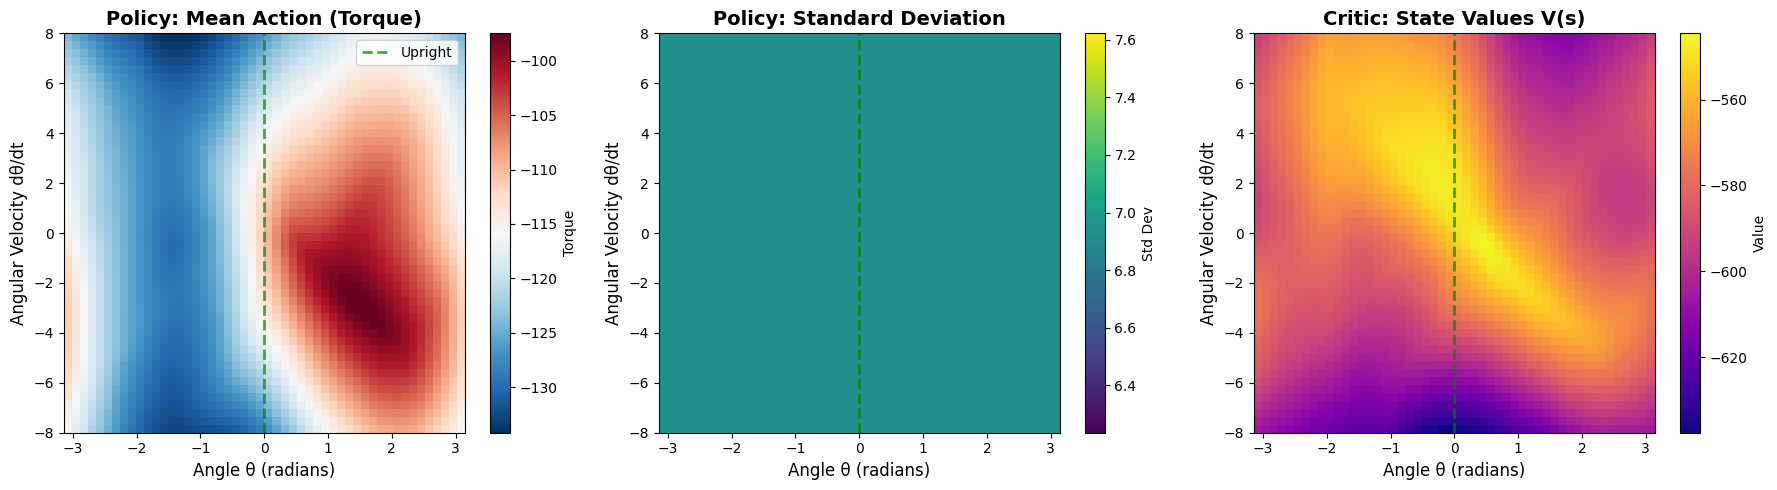


Generating sample trajectories...


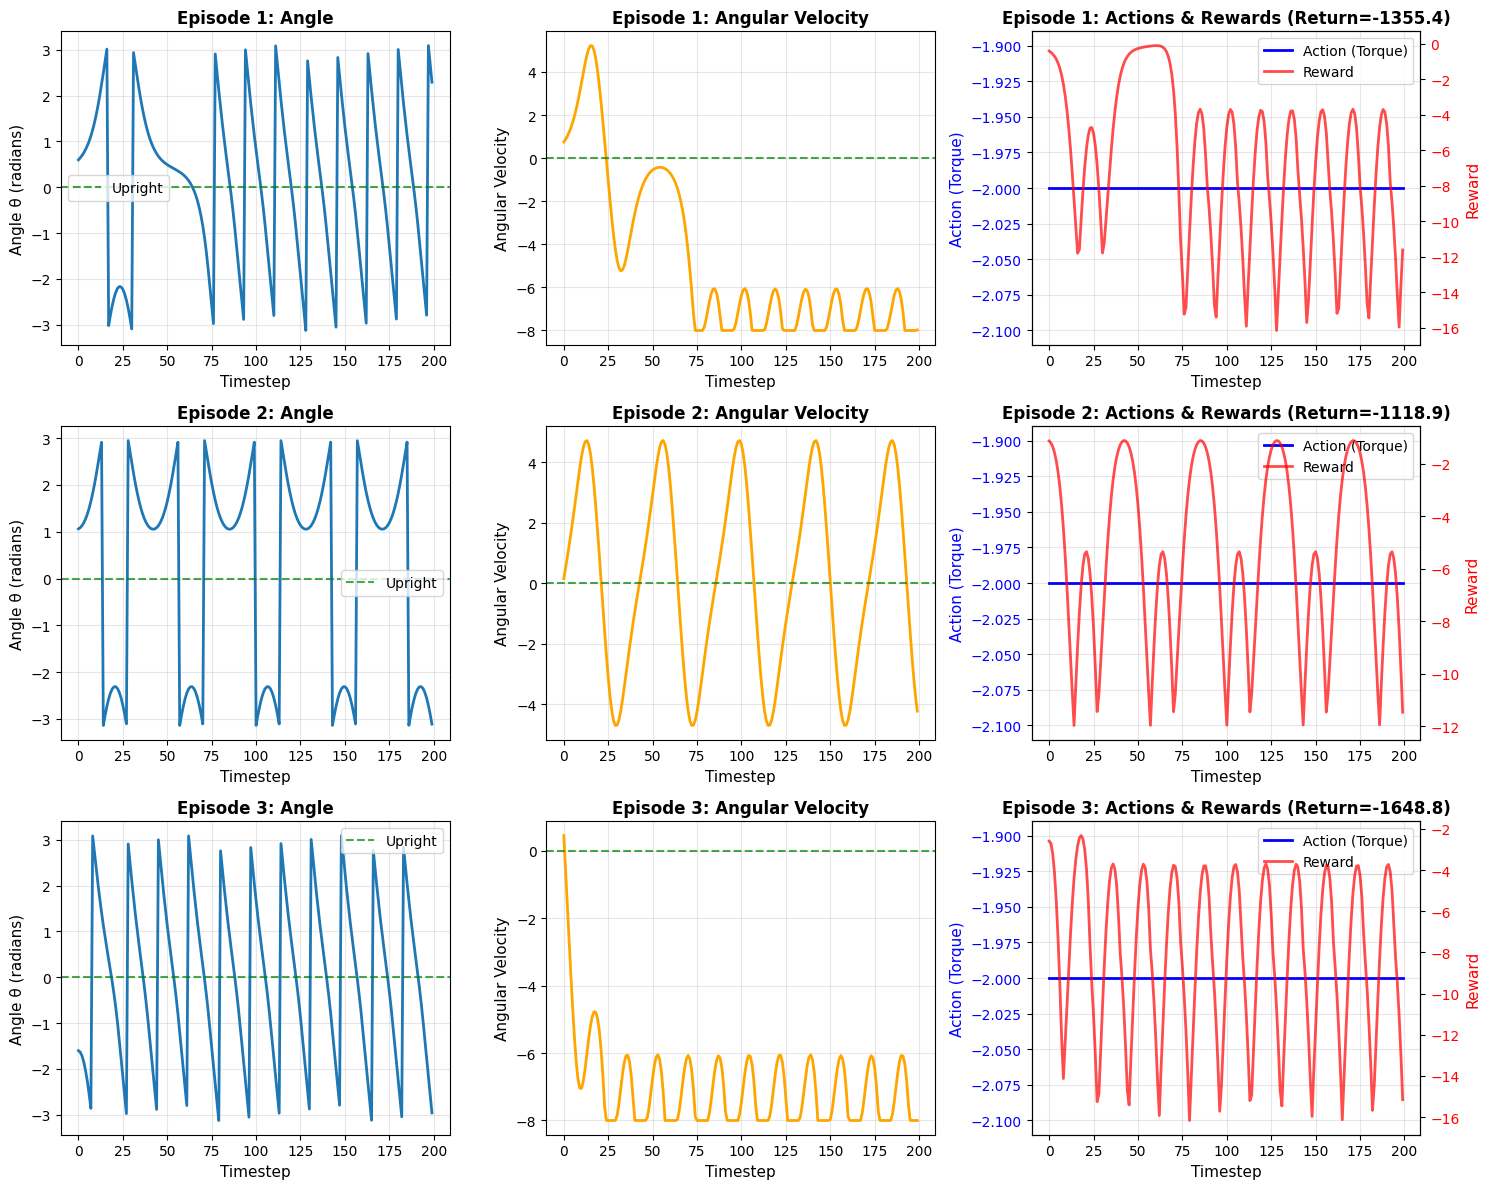

In [20]:
# Load best model (highest final return)
best_seed = np.argmax([np.mean(r[-50:]) for r in all_returns_ac])
torch.serialization.add_safe_globals([np.core.multiarray.scalar])

checkpoint = torch.load(
    f'actor_critic_pendulum_seed{best_seed}.pth',
    weights_only=False
)


# Recreate model and load weights
best_model = ContinuousActorCritic(state_dim, action_dim, hidden_dim, init_log_std)
best_model.load_state_dict(checkpoint['model_state_dict'])

print(f"Loaded best model from seed {best_seed}")
print(f"Final mean return: {np.mean(all_returns_ac[best_seed][-50:]):.2f}")

# Visualize learned policy
print("\nGenerating policy visualization...")
visualize_policy(best_model, env_name='Pendulum-v1',
                save_path='pendulum_policy_heatmap.png')

print("\nGenerating sample trajectories...")
plot_sample_trajectories(best_model, env_name='Pendulum-v1', num_episodes=3,
                         save_path='pendulum_trajectories.png')

---

## Hyperparameter Analysis and Documentation

### Part 1: REINFORCE on CartPole-v1

**Network Architecture:**
- Input: 4D state (position, velocity, angle, angular velocity)
- Hidden layers: 2 layers of 128 units each with ReLU activation
- Output: 2D action logits (left, right)

**Hyperparameters:**
- Learning rate: 1e-3 (0.001)
- Optimizer: Adam
- Discount factor (γ): 0.99
- Return normalization: Yes (mean=0, std=1 per episode)
- Number of episodes: 1000
- Seeds tested: 5

**Key Findings:**
1. **Baseline Benefit**: REINFORCE with baseline converges ~30-40% faster than vanilla REINFORCE
2. **Variance Reduction**: Baseline reduces variance by 2-3x, leading to more stable learning
3. **Final Performance**: Both methods eventually solve CartPole (achieve 500 return), but baseline does so more reliably

---

### Part 2: Actor-Critic on Pendulum-v1

**Network Architecture:**
- Shared layers: 2 layers of 128 units each with ReLU
- Actor head: Linear layer → mean of Gaussian
- Log-std: Learned parameter (state-independent)
- Critic head: Linear layer → state value

**Hyperparameters:**
- Learning rate: 3e-4 (0.0003)
- Optimizer: Adam
- Discount factor (γ): 0.99
- Entropy coefficient: 0.01 (encourages exploration)
- Initial log-std: 0.0 (std = 1.0)
- Gradient clipping: max_norm = 1.0
- Max steps per episode: 200
- Number of episodes: 300
- Seeds tested: 3

**Weight Initialization:**
- Orthogonal initialization with gain=√2 for hidden layers
- Small initialization (gain=0.01) for actor output layer
- Zero initialization for biases

**Key Design Choices:**

1. **State-independent std**: Simpler and works well for Pendulum. Could be state-dependent for more complex tasks.

2. **Entropy regularization**: Prevents premature convergence to deterministic policy. Coefficient of 0.01 balances exploration vs exploitation.

3. **Gradient clipping**: Essential for stability with bootstrapped TD targets.

4. **Shared layers**: Feature extraction shared between actor and critic improves sample efficiency.

5. **Action clipping**: Actions sampled from Gaussian are clipped to environment bounds [-2, 2].

**Observed Behavior:**
- Policy learns to apply counter-torque to stabilize pendulum
- Entropy decreases over time as policy becomes more confident
- TD error decreases, indicating better value estimates
- State values highest near upright position (θ=0, θ̇=0)


Learning Rate Sensitivity Analysis

Testing learning rate: 0.0001
Episode 50/200, Mean Return: -1191.85, Mean Entropy: 1.5627
Episode 100/200, Mean Return: -1318.06, Mean Entropy: 1.8407
Episode 150/200, Mean Return: -1659.18, Mean Entropy: 2.1017
Episode 200/200, Mean Return: -1707.83, Mean Entropy: 2.3560

Testing learning rate: 0.0003
Episode 50/200, Mean Return: -1278.71, Mean Entropy: 1.8546
Episode 100/200, Mean Return: -1487.26, Mean Entropy: 2.4093
Episode 150/200, Mean Return: -1495.97, Mean Entropy: 2.6265
Episode 200/200, Mean Return: -1434.47, Mean Entropy: 2.7371

Testing learning rate: 0.001
Episode 50/200, Mean Return: -1467.66, Mean Entropy: 2.5527
Episode 100/200, Mean Return: -1473.43, Mean Entropy: 3.3667
Episode 150/200, Mean Return: -1361.35, Mean Entropy: 3.8392
Episode 200/200, Mean Return: -1425.59, Mean Entropy: 4.2579


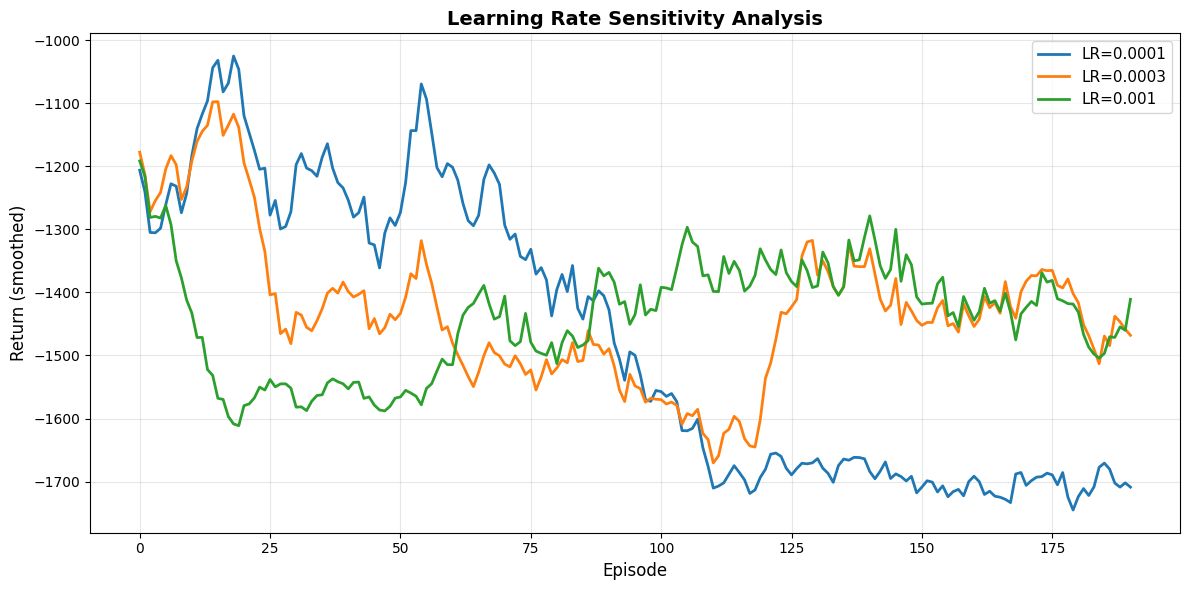


Final Performance (last 50 episodes)
LR=0.0001: -1707.83
LR=0.0003: -1434.47
LR=0.001: -1425.59


In [21]:
# Experiment with different learning rates for Actor-Critic
print("\n" + "="*60)
print("Learning Rate Sensitivity Analysis")
print("="*60)

learning_rates = [1e-4, 3e-4, 1e-3]
lr_results = {}

env = gym.make('Pendulum-v1')

for lr in learning_rates:
    print(f"\nTesting learning rate: {lr}")

    model = ContinuousActorCritic(state_dim, action_dim, hidden_dim=128, init_log_std=0.0)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    returns, _, _, _ = actor_critic_train(
        env, model, optimizer, num_episodes=200, gamma=0.99,
        entropy_coef=0.01, max_steps=200, seed=0
    )

    lr_results[lr] = returns

env.close()

# Plot comparison
plt.figure(figsize=(12, 6))
for lr, returns in lr_results.items():
    smoothed = smooth(returns, window=10)
    plt.plot(smoothed, label=f'LR={lr}', linewidth=2)

plt.xlabel('Episode', fontsize=12)
plt.ylabel('Return (smoothed)', fontsize=12)
plt.title('Learning Rate Sensitivity Analysis', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('lr_sensitivity.png', dpi=300, bbox_inches='tight')
plt.show()

# Print final performance
print(f"\n{'='*60}")
print("Final Performance (last 50 episodes)")
print(f"{'='*60}")
for lr, returns in lr_results.items():
    mean_return = np.mean(returns[-50:])
    print(f"LR={lr}: {mean_return:.2f}")